In [32]:
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
from matplotlib_venn import venn2_unweighted, venn3_unweighted

In [2]:
#!cd
!python ../src/masskit/apps/process/libraries/pubchem_links.py

Attempting to find or download data files:
Using cache file C:\Users\slottad\.masskit_cache\pubchem\pubchem-wiki.json
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-InChI-Key.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-Patent.gz
Using cache file C:\Users\slottad\.masskit_cache\pubchem\CID-PMID.gz


In [19]:
# Load NIST Library data files
nist_files = [
    '~/data/nist/ei/2023/main_2023.parquet',
    '~/data/nist/ei/2023/rep_2023.parquet',
    '~/data/nist/ei/2023/ri_2023.parquet',
    '~/data/nist/tandem/2023/apci_msms_2023.parquet',
    '~/data/nist/tandem/2023/hr_msms_2023.parquet',
    '~/data/nist/tandem/2023/lr_msms_2023.parquet'
]
tables = []
for file in nist_files:
    table = pq.read_table(file, columns=['id', 'name', 'inchi_key', 'inchi_key_orig'])
    tables.append(table)
tables

[pyarrow.Table
 id: uint64
 name: string
 inchi_key: string
 inchi_key_orig: string
 ----
 id: [[1,2,3,4,5,...,4997,4998,4999,5000,5001],[5002,5003,5004,5005,5006,...,9997,9998,9999,10000,10001],...,[340009,340010,340011,340012,340013,...,345004,345005,345006,345007,345008],[345009,345010,345011,345012,345013,...,347101,347102,347103,347104,347105]]
 name: [["Hydrogen","Deuterium","Diazirine","Methane, diazo-","Ketene",...,"Pentafluoropropionamide, N-allyl-N-(3-methylbutyl)-","5-Bromo-2-cyclopentylamino-3-nitropyridine","4H-1-Benzopyran-4-one, 5-hydroxy-2-methyl-7-(2-propenyloxy)-","3,4'-Dimethyl-2,3'-dioxobicyclohexyl-5-ene-3,4'-dicarboxylic acid, dimethyl ester","Eudesma-4(14),7(11)-dien-8-one"],["2-Diallylamino-N-phenyl-2-thioxo-acetamide","Allyl-(4,6-di-piperidin-1-yl-[1,3,5]triazin-2-yl)-amine","Cyclopropanecarboxamide, N-[7-(cyclopropylcarbonyl)-2,3-dihydro-1,4-benzodioxin-6-yl]-","Acetamide, 2-(cyclohexylamino)-N-(5,6,7,8-tetrahydro-2-methyl-4-oxo[1]benzothieno[2,3-d]pyrimidin-3

In [30]:
# Get the set of INCHI Keys from the NIST Libraries
inchi_keys = pa.concat_arrays( [ i.column("inchi_key").combine_chunks() for i in tables ] )
inchi_keys_orig = pa.concat_arrays( [ i.column("inchi_key_orig").combine_chunks() for i in tables ] )

ik_set = set(inchi_keys.unique().to_pylist())
ik_orig_set = set(inchi_keys_orig.unique().to_pylist())
ik_full_set = ik_set | ik_orig_set

In [41]:
cid2inchi_full = pq.read_table('~/.masskit_cache/pubchem/cid-inchi.parquet', columns=['cid', 'inchi_key'])
table2 = pa.table({'inchi_key': ik_full_set})
cid2inchi = cid2inchi_full.join(table2,keys='inchi_key',join_type='inner')

In [42]:
pubchem_inchi = set(cid2inchi['inchi_key'].to_pylist())

pyarrow.Table
cid: int64
inchi_key: string
----
cid: [[1018148,1019313,1019368,1019468,1019672,...,91735506,91735507,91735508,91735509,91735510],[254019,254079,254130,254132,254139,...,162623974,163247572,163953061,165505305,166945550],...,[1757002,1757003,1757488,1758358,1758442,...,165949017,165949996,165950874,166624776,166636724],[2046769,2048020,2048937,2049051,2049536,...,165990562,165991790,165995526,166662043,167408391]]
inchi_key: [["LWWAMJZNCTZXPY-UHFFFAOYSA-N","DJRBMOVUOGAVDK-UHFFFAOYSA-N","AFOBGMXEPQXMGB-UHFFFAOYSA-N","VTVLWVLMDYRPGZ-UHFFFAOYSA-N","QMAZIBROTWQTNU-ZROIWOOFSA-N",...,"UGQRYUCIRQOFJE-UHFFFAOYSA-N","GOOZCRZDKVZRRM-UHFFFAOYSA-N","GJNQAUDUKXVGRR-UHFFFAOYSA-N","HVUOJSPHCWFURD-UHFFFAOYSA-N","URJMGPFJUQWNQO-UHFFFAOYSA-N"],["MSWJZKFRTYHAJD-UHFFFAOYSA-N","IEAJHLSDPVLRQQ-UHFFFAOYSA-N","ASBWJERTCCTIMI-UHFFFAOYSA-N","WRWGCPXFAJKWDW-UHFFFAOYSA-N","GYBSXVSGJLAHDV-UHFFFAOYSA-N",...,"PHWAYZMUFKPAIM-UHFFFAOYSA-N","RCCXXTZQHLEIBY-UHFFFAOYSA-N","SAZWZIOPFNSJOS-UHFFFAOYSA-N","WVA

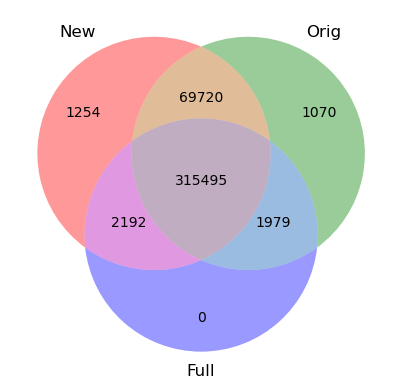

In [43]:
# Show overlaps
venn3_unweighted([ik_set,ik_orig_set, pubchem_inchi],set_labels=("New","Orig", "Full"))

In [14]:
#inchi_ne = (pc.not_equal(pc.field("inchi_key"), pc.field("inchi_key_orig")))
inchi_ne = (pc.field("inchi_key") != pc.field("inchi_key_orig"))
#inchi_ne
tables[0].filter(inchi_ne).shape

(351, 4)

In [9]:
mask = pc.equal(tables[0].column("inchi_key"), tables[0].column("inchi_key_orig"))
mask

[
  [
    true,
    true,
    true,
    true,
    true,
    ...
    true,
    true,
    true,
    true,
    true
  ]
]